# Chatbot con Red Neuronal Sequential (Keras)

Librerías necesarias:

In [3]:
## Librerías:
# ... Para 'intents.json'
import json # Para el formato json
import codecs # Lectura de caracteres en español (tildes y 'ñ')
# ... Procesamiento de Lenguaje Natural
import spacy # Lemmatizer (convertir palabras) con lenguaje español
import pickle # Guardar archivos
import numpy as np 
import nltk # Natural Language ToolKit: Tokenizar
from recursos import lemmatizer, normalize_tilde

Para crear la Red Neuronal Secuencial con Keras:

In [4]:
# Redes Neuronales:
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD

## Entrenamiento
El siguiente código es el mismo que se puede encontrar en *training.py*

In [4]:
## 1. Cargar la información del archivo json

def load_training_data(json_file = "intents.json"):
    # Cargar archivo json:
    intents = json.loads(codecs.open(json_file, encoding='utf-8').read())
    
    words = [] # Palabras individuales usadas
    tags = [] # Etiquetas de intención
    ignore_letters = ['¿', '?', '.', ',', ';', '¡', '!', '(', ')']
    documents = [] # Lista de tuplas ([Lista de palabras], etiqueta asociada de intención)
    for intent in intents['intents']:
        # Por cada intención:
        for pattern in intent['patterns']:
            # Tokenizar el patrón de palabras que usaría el usuario y agregar las palabras a 'words'.
            pattern = lemmatizer(pattern) #........ Para separar '¿__w1__w2' y pasar palabras a su forma base.
            pattern = normalize_tilde(pattern) #... Quitas las tildes.
            word_list = nltk.word_tokenize(pattern)
            words.extend(word_list)
            # Agregar a 'documents' la tupla (lista de palabras, etiqueta de la intención)
            documents.append((word_list, intent['tag']))
            if intent['tag'] not in tags:
                tags.append(intent['tag'])
            # Fin del segundo bucle
        # Fin del primer bucle
    words = [lemmatizer(word.lower()) for word in words if word not in ignore_letters]
    words = sorted(set(words))
    tags = sorted(set(tags))
    """
    Ejemplo:
    - words = ['Buen', 'Hola', 'día', ...]
    - tags = ['saludos', 'opciones', 'consulta_lugar']
    - documents = [(['Buen', 'día'], 'saludos'), (['Hola'], 'saludos'), ([...], 'opciones'), ...]
    """
    return words, tags, documents

words, tags, documents = load_training_data() # 'documents' ayudará a crear la matriz de entrenamiento
print("intents.json cargado")
print("Palabras detectadas:", len(words))
print("Intenciones detectadas:", len(tags))

intents.json cargado
Palabras detectadas: 138
Intenciones detectadas: 13


In [5]:
# ... Guardar las palabras y tags
pickle.dump(words, open('words.pkl', 'wb'))
pickle.dump(tags, open('tags.pkl', 'wb'))

# 2. Bag of Words: Formar matriz Training 

training = []
output_empty = [0] * len(tags)

for document in documents:
    # Por cada tupla ([consulta de palabras], tag)
    bag = [] # ... bag of words
    word_patterns = document[0] #... lista de palabras
    word_patterns = [lemmatizer(word.lower()) for word in word_patterns] #... lematizar las palabras en minúsculas
    for word in words:
        # Por cada palabra en el conjunto total de palabras encontradas en el archivo json.
        bag.append(1) if word.lower() in word_patterns else bag.append(0)
        # Si dicha palabra está entre el patrón de este documento: 1; else -> 0
    # - bag = [0,0,0,...,1], de len(bag) = len(words)
    
    output_row = list(output_empty) # Hacer una lista de 0, del tamaño de len(tags)
    output_row[tags.index(document[1])] = 1 # Cambia a '1' la celda de mismo índice que tag en tags.
    training.append([bag, output_row]) # Se agrega a la matriz de Training.

random.shuffle(training) # Mezclar Data de Entrenamiento
training = np.array(training)
print("Formada matriz training. Filas: %s, Etiquetas:%s)"%(len(training), len(training[0][1])))

train_x = list(training[:,0]) # Entradas
train_y = list(training[:,1]) # Salidas

model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation = 'softmax'))

sgd = SGD(lr = 0.01, decay =1e-6, momentum=0.9, nesterov = True)

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.fit(np.array(train_x), np.array(train_y), epochs=200, batch_size=5, verbose = 1)
model.save('chatbot_model.model')
print("Red Neuronal Guardada")

Formada matriz training. Filas: 169, Etiquetas:13)
Train on 169 samples
Epoch 1/200
169/169 [==============================] - 4s 22ms/sample - loss: 2.5455 - accuracy: 0.1124
Epoch 2/200
169/169 [==============================] - 0s 846us/sample - loss: 2.4072 - accuracy: 0.2485
Epoch 3/200
169/169 [==============================] - 0s 1ms/sample - loss: 2.2408 - accuracy: 0.2367
Epoch 4/200
169/169 [==============================] - 0s 1ms/sample - loss: 2.0138 - accuracy: 0.3373
Epoch 5/200
169/169 [==============================] - 0s 1ms/sample - loss: 1.8490 - accuracy: 0.3728
Epoch 6/200
169/169 [==============================] - 0s 1ms/sample - loss: 1.6009 - accuracy: 0.5562
Epoch 7/200
169/169 [==============================] - 0s 1ms/sample - loss: 1.5688 - accuracy: 0.48520s - loss: 1.5964 - accuracy: 0.
Epoch 8/200
169/169 [==============================] - 0s 1ms/sample - loss: 1.3058 - accuracy: 0.5621
Epoch 9/200
169/169 [==============================] - 0s 1ms/sample 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: chatbot_model.model\assets


INFO:tensorflow:Assets written to: chatbot_model.model\assets


Red Neuronal Guardada


## Estudiar el Chatbot

Cargar el modelo de Red Neuronal:

In [5]:
from tensorflow.keras.models import load_model

model = load_model('chatbot_model.model')
words = pickle.load(open('words.pkl','rb'))
tags = pickle.load(open('tags.pkl','rb'))
print(tags)

['consulta_categoria', 'consulta_funciones', 'consulta_lugar', 'consulta_lugares_cerca', 'consulta_precio', 'consulta_recomendacion', 'consulta_tiempo', 'consulta_trivia', 'contexto', 'despedida', 'gracias', 'nulo', 'saludos']


Funciones para la representación de Bag of Words.

Estas funciones son las mismas que se usan en chatbot.py

In [6]:
def clean_up_sentence(sentence):
    """
    Limpiar oración de entrada (lematizar cada palabra)
    """
    sentence_words = nltk.word_tokenize(sentence)
    sentence_words = [lemmatizer(word) for word in sentence_words]
    return sentence_words

def bag_of_words(sentence):
    """
    Convertir la oración de entrada a bag_of_words
    """
    sentence_words = clean_up_sentence(sentence)
    # sentence_words: Arreglo de las palabras lematizadas
    bag = [0] * len(words)
    # bag: Arreglo de 0s
    for w in sentence_words:
        for i, word in enumerate(words):
            if word == w:
                bag[i] = 1
                # Cambiar a '1' donde haya incidencia (bag of words)
    return np.array(bag)

### Conjunto de datos de prueba

In [7]:
test_intents = json.loads(codecs.open('test_intents.json', encoding='utf-8').read())

X_test = []
Y_test_array = []
Y_test_tagged = []

for intent in test_intents['intents']:
    for pattern in intent['patterns']:
        pattern = lemmatizer(pattern.lower())
        bow = bag_of_words(pattern)
        X_test.append(bow)
        Y_test_tagged.append(intent['tag'])
        
        output_row = list([0 for i in range(len(tags))]) # Hacer una lista de 0, del tamaño de len(tags)
        output_row[tags.index(intent['tag'])] = 1 # Cambia a '1' la celda de mismo índice que tag en tags.
        Y_test_array.append(output_row)

#print("X:")  
#print(X_test[:2])
#print("Y:")
#print(Y_test_array[:5])
#print("Y:")
#print(Y_test_tagged[:5])

In [8]:
def make_predict(bow):
    """
    * bow: Arreglo representación Bag of Words
    """
    res = model.predict(np.array([bow]))[0] # Recibe el resultado del modelo, recibiendo como entrada 'bow' (ver línea de arriba, 45)
    ERROR_THRESHOLD = 0.25
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    # Si 'resultado' es mayor que el umbral, entonces considera el par [indice del 'resultado', 'resultado']
    results.sort(key=lambda x: x[1], reverse=True)
    # Ordenar resultados según la mayor probabilidad (Softmax como capa de salida)
    y_pred = [0 for _ in range(len(tags))]
    y_pred[results[0][0]] = 1
    return list(y_pred), tags[results[0][0]]

y_pred_array = []
y_pred_tags = []
for sentence_bow in X_test:
    pred, tag = make_predict(sentence_bow)
    y_pred_array.append(pred)
    y_pred_tags.append(tag)

In [9]:
print("Pred:")
print(y_pred_array[10:13])
print(y_pred_tags[10:13])
print("Test:")
print(Y_test_tagged[10:13])

Pred:
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
['saludos', 'saludos', 'saludos']
Test:
['saludos', 'saludos', 'saludos']


In [10]:
print(" ".ljust(25,' ') + " Reales \t Predicho")
for tag in tags:
    aux = tag.ljust(25, ' ')
    aux += " %s \t \t %s"%(Y_test_tagged.count(tag),y_pred_tags.count(tag))
    print(aux)

                          Reales 	 Predicho
consulta_categoria        8 	 	 8
consulta_funciones        12 	 	 11
consulta_lugar            22 	 	 16
consulta_lugares_cerca    10 	 	 10
consulta_precio           13 	 	 16
consulta_recomendacion    13 	 	 13
consulta_tiempo           16 	 	 14
consulta_trivia           15 	 	 17
contexto                  12 	 	 11
despedida                 18 	 	 17
gracias                   9 	 	 9
nulo                      1 	 	 6
saludos                   22 	 	 23


### Matriz de confusión

Podemos calcular las 13 matrices de confusión binarias para cada categoría

In [19]:
from sklearn.metrics import multilabel_confusion_matrix

mcm = multilabel_confusion_matrix(Y_test_array, y_pred_array)

print(tags[0])
print(mcm[0])

consulta_categoria
[[162   1]
 [  1   7]]


O una matriz de confusión multicategórica:

In [12]:
from sklearn.metrics import confusion_matrix
import pandas as pd

cm = confusion_matrix(Y_test_tagged, y_pred_tags)
print("Matriz de Confusión:")
print(cm)

def normalizar_matriz(matriz):
    row_sums = matriz.sum(axis=1)
    new_matrix = matriz / row_sums[:, np.newaxis]
    new_matrix = np.array([[round(c,2) for c in row] for row in new_matrix]) 
    return new_matrix

normal_cm = normalizar_matriz(cm)
print("Matriz Normalizada:")
cm_df = pd.DataFrame(normal_cm,
                     index = list(tags), 
                     columns = list(tags))
cm_df

Matriz de Confusión:
[[ 7  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0 11  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0 15  0  3  0  0  2  0  0  0  2  0]
 [ 0  0  0 10  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 13  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 12  0  0  0  0  0  1  0]
 [ 0  0  1  0  0  1 14  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 15  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0 11  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 17  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1 21]]
Matriz Normalizada:


,consulta_categoria,consulta_funciones,consulta_lugar,consulta_lugares_cerca,consulta_precio,consulta_recomendacion,consulta_tiempo,consulta_trivia,contexto,despedida,gracias,nulo,saludos
consulta_categoria,0.88,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.12
consulta_funciones,0.00,0.92,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.08
consulta_lugar,0.00,0.00,0.68,0.0,0.14,0.00,0.00,0.09,0.00,0.00,0.0,0.09,0.00
consulta_lugares_cerca,0.00,0.00,0.00,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
consulta_precio,0.00,0.00,0.00,0.0,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
consulta_recomendacion,0.00,0.00,0.00,0.0,0.00,0.92,0.00,0.00,0.00,0.00,0.0,0.08,0.00
consulta_tiempo,0.00,0.00,0.06,0.0,0.00,0.06,0.88,0.00,0.00,0.00,0.0,0.00,0.00
consulta_trivia,0.00,0.00,0.00,0.0,0.00,0.00,0.00,1.00,0.00,0.00,0.0,0.00,0.00
contexto,0.08,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.92,0.00,0.0,0.00,0.00
despedida,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.94,0.0,0.06,0.00


La matriz de confusión normalizada está distribuida de tal manera que las columnas son la etiqueta dada por la red neuronal y las filas las etiquetas reales. Cada fila tiene un subtotal ($1$).
Cada fila $i$ representa la categoría $tag_i$ real. Cada celda de una fila $i$ representa el porcentaje de instancias reales $tag_i$ que fueron clasificadas con $tag_j$, dado que está ubicado en la columna $j$.
Entonces, cada celda en la diagonal de la matriz representa la $tasa\ de\ verdaderos\ positivos$ de cada categoría.

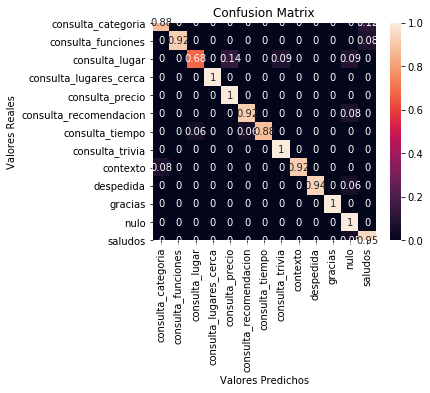

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

Entre los resultados, destaca la tasa de verdaderos positivos del modelo con la categoría $consulta\_lugar$, con $0.68$. Esto quiere decir, que de todas las oraciones con intención de consultar por la dirección del lugar, la red neuronal solo identifica correctamente el $68\%$

### Curva ROC

A partir de las métricas $TPR$ (*True positive rate*, o *tasa de verdaderos positivos*) y $FPR$ (*Tasa de falsos positivos*), se puede construir una curva ROC.

* $TPR = \frac{Verdaderos\ Positivos}{Verdaderos\ Positivos + Falsos\ Negativos}$
* $FPR = \frac{Falsos\ Positivos}{Falsos\ Positivos + Verdaderos\ Positivos}$

Entonces, podemos calcular puntualmente estas métricas por categoría:

In [35]:
# Matriz es:
# ............Pred F ......... | ... Pred T
# Real F  Verdaderos Negativos | Falsos Positivos
# Real T  Falsos Negativos     | Verdaderos Positivos
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

print("  Tag".ljust(25,' ') + "TPR".ljust(20,' ') + "FPR".ljust(20,' '))

positive_rates = []
for i, m in enumerate(mcm):
    tpr = m[1][1] / (m[1][1] + m[1][0])
    fpr = m[0][1] / (m[0][1] + m[1][1])
    positive_rates.append([tpr,fpr])
    aux = tags[i].ljust(25,' ') + str(tpr).ljust(20,' ') + str(fpr).ljust(20,' ')
    print(aux)

  Tag                    TPR                 FPR                 
consulta_categoria       0.875               0.125               
consulta_funciones       0.9166666666666666  0.0                 
consulta_lugar           0.6818181818181818  0.0625              
consulta_lugares_cerca   1.0                 0.0                 
consulta_precio          1.0                 0.1875              
consulta_recomendacion   0.9230769230769231  0.07692307692307693 
consulta_tiempo          0.875               0.0                 
consulta_trivia          1.0                 0.11764705882352941 
contexto                 0.9166666666666666  0.0                 
despedida                0.9444444444444444  0.0                 
gracias                  1.0                 0.0                 
nulo                     1.0                 0.8333333333333334  
saludos                  0.9545454545454546  0.08695652173913043 


In [45]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

roc_aux = []
for tag in tags:
    aux_y_test = [1 if y == tag else 0 for y in Y_test_tagged]
    aux_y_pred = [1 if y == tag else 0 for y in y_pred_tags]
    #tag_test_pred.append([aux_y_test, aux_y_pred])
    false_positive_rate, true_positive_rate, thresholds = roc_curve(aux_y_test, aux_y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    roc_aux.append([false_positive_rate, true_positive_rate, roc_auc])

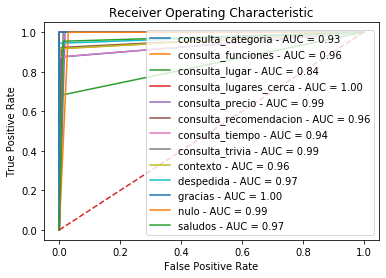

In [53]:
plt.title('Receiver Operating Characteristic')
for i, aux in enumerate(roc_aux):
    plt.plot(aux[0], aux[1], label = "%s - AUC = %0.2f"%(tags[i], aux[2]))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()